# **Klasifikasi Ketepatan Penggunaan Masker dengan Convolutional Neural Network**

Created by Yohanes Setiawan

# Business Understanding

* Saat ini, penggunaan masker berfungsi sebagai salah satu protokol kesehatan semenjak pandemi Covid-19. Masker digunakan di lokasi yang ramai agar penyebaran penyakit dapat diminimalisir
* Namun, masih banyak orang yang menggunakan masker hanya sebagai kewajiban sehingga tidak memperhatikan ketepatan menggunakan masker. Selain itu, masih ada oknum yang enggan menggunakan masker di tempat umum
* Tugas ini melakukan klasifikasi ketepatan penggunaan masker untuk membantu deteksi oknum yang tidak menggunakan masker maupun yang tidak tepat menggunakan masker
* Convolution Neural Network (CNN) digunakan dalam tugas ini dikarenakan kompleksitas layer-nya yang memudahkan klasifikasi citra tanpa harus melakukan ekstraksi fitur seperti metode pemrosesan citra tradisional
* Sistem ini akan mendeteksi dalam 3 kategori: with_mask (menggunakan masker), without_mask (tidak menggunakan masker), dan incorrect_mask (ketidaktepatan penggunaan masker)

# Data Understanding

* Dataset diperoleh melalui Kaggle: https://www.kaggle.com/datasets/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask
* Terdiri atas: 690 with_mask, 703 citra without_mask, dan 686 citra incorrect_mask

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import splitfolders
import os, os.path
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import numpy as np
from google.colab import files
import keras.utils as image

2.11.0


In [ ]:
# Running once, no need to run it again!
"""
input_folder = "/content/drive/MyDrive/FSB/dataset" #Enter Input Folder
output = "/content/drive/MyDrive/FSB/dataset" #Enter Output Folder

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.7,0.3))
"""

'\ninput_folder = "/content/drive/MyDrive/FSB/dataset" #Enter Input Folder\noutput = "/content/drive/MyDrive/FSB/dataset" #Enter Output Folder\n\nsplitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.7,0.3))\n'

In [ ]:
# path joining version for other paths
DIR = '/content/drive/MyDrive/FSB/dataset/train'
print ("Training data", sum(len(files) for _, _, files in os.walk(DIR)))
DIR = '/content/drive/MyDrive/FSB/dataset/val'
print ("Testing data", sum(len(files) for _, _, files in os.walk(DIR)))

Training data 1457
Testing data 627


In [ ]:
#Memasukkan semua data ke variabel
base_dir = '/content/drive/MyDrive/FSB/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

#Direktori data training
train_one_dir = os.path.join(train_dir, 'incorrect_mask')
train_two_dir = os.path.join(train_dir, 'with_mask')
train_three_dir = os.path.join(train_dir, 'without_mask')
 
#Direktori data testing
validation_one_dir = os.path.join(validation_dir, 'incorrect_mask')
validation_two_dir = os.path.join(validation_dir, 'with_mask')
validation_three_dir = os.path.join(validation_dir, 'without_mask')

In [ ]:
# Check Image Size

folder_images1 = "/content/drive/MyDrive/FSB/dataset/train/incorrect_mask"
folder_images2 = "/content/drive/MyDrive/FSB/dataset/train/with_mask"
folder_images3 = "/content/drive/MyDrive/FSB/dataset/train/without_mask"
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images3):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}
print(size_images)

{'234.jpg': {'width': 290, 'heigth': 417}, '328.jpg': {'width': 576, 'heigth': 960}, '232.jpg': {'width': 320, 'heigth': 433}, '297.jpg': {'width': 313, 'heigth': 449}, '368.jpg': {'width': 363, 'heigth': 408}, '428.jpg': {'width': 199, 'heigth': 254}, '242.jpg': {'width': 320, 'heigth': 428}, '425.jpg': {'width': 320, 'heigth': 428}, '411.jpg': {'width': 114, 'heigth': 141}, '351.jpg': {'width': 213, 'heigth': 237}, '185.jpg': {'width': 270, 'heigth': 152}, '101.jpg': {'width': 320, 'heigth': 428}, '13.jpg': {'width': 320, 'heigth': 428}, '409.jpg': {'width': 639, 'heigth': 639}, '347.jpg': {'width': 183, 'heigth': 275}, '119.jpg': {'width': 320, 'heigth': 428}, '10.jpg': {'width': 274, 'heigth': 366}, '159.jpg': {'width': 201, 'heigth': 289}, '3.jpg': {'width': 320, 'heigth': 433}, '393.jpg': {'width': 467, 'heigth': 518}, '221.jpg': {'width': 320, 'heigth': 428}, '301.jpg': {'width': 363, 'heigth': 395}, '360.jpg': {'width': 320, 'heigth': 433}, '298.jpg': {'width': 297, 'heigth': 4

# Image Preprocessing


Dilakukan image pre-processing dengan image augmentation untuk memunculkan transformasi data baru berdasarkan data yang sudah ada.

Karena kasus ini adalah deteksi ketepatan penggunaan masker, maka image augmentation yang saya lakukan adalah:
* rescaling dengan merubah pixel menjadi diantara 0 dan 1
* melakukan rotasi pada image sebesar 30 derajat untuk mengatasi foto dengan rotasi yang berlainan
* width dan height shift digunakan untuk shifting citra untuk sudut pandang wajah yang berbeda
* brightness range untuk mengatasi kekurangan cahaya pada foto
* shear range untuk memiringkan bentuk dari citra
* fill_mode = 'nearest' sebagai pilihan default ketika pixel terdekat dipilih dan diulangin untuk setiap nilai pixel

In [ ]:
# Image augmentation

train_datagenerator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=90, #random rotation antara 0-90 derajat
                    width_shift_range=0.2, #prosentasi width untuk random shift
                    height_shift_range=0.2, #prosentasi height untuk random shift
                    horizontal_flip=True, #horizontal flip untuk posisi tangan horizontal
                    brightness_range=[0.2,1.0], #mainkan brightness kalau ada kekurangan cahaya
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagenerator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=90, #random rotation antara 0-90 derajat
                    width_shift_range=0.2, #prosentasi width untuk random shift
                    height_shift_range=0.2, #prosentasi height untuk random shift
                    horizontal_flip=True, #horizontal flip untuk posisi tangan horizontal
                    brightness_range=[0.3,1.0], #mainkan brightness kalau ada kekurangan cahaya
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
#Persiapan Data Training dan Validasi Generator
train_generator = train_datagenerator.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 256x256 piksel
        batch_size=4,
        # Klasifikasi Multi-Class (>2)
        class_mode='categorical')
 
validation_generator = test_datagenerator.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 256x256 piksel
        batch_size=4, 
        # Klasifikasi Multi-Class (>2)
        class_mode='categorical')
X, y = next(train_generator)

Found 1457 images belonging to 3 classes.
Found 627 images belonging to 3 classes.


# Modelling

In [ ]:
#Penggunaan Callback untuk menghentikan proses training sesuai akurasi yang diinginkan

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9 and logs.get('accuracy')>0.9):
      print("\nSudah >90% nih akurasinya jadi diberhentikan saja!")
      self.model.stop_training = True

callbacks = myCallback()

#Model sederhana Deep Learning 5 Conv dan 2 Fully Connected Layer
model = tf.keras.models.Sequential([ #Menggunakan model Sequential 
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3), #melakukan dropout pada 20% dari unit output
  tf.keras.layers.Dense(3, activation='softmax') #3 kelas (???)
])

# Meng-compile model dengan Adam Optimizer dengan loss Categorical_Crossentropy karena multiclass classification
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(), 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
start_time = time.time() #Hitung waktu eksekusi training
epoh = 200 #Tentukan banyaknya epoch-nya
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # Ini batch
      epochs=epoh, # Ini epoch
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      callbacks=[callbacks],
      verbose=2)
print("--- Waktu training adalah %s detik ---" % (time.time() - start_time))

Epoch 1/200
25/25 - 61s - loss: 1.1293 - accuracy: 0.4300 - val_loss: 1.0578 - val_accuracy: 0.4000 - 61s/epoch - 2s/step
Epoch 2/200
25/25 - 65s - loss: 1.0727 - accuracy: 0.4000 - val_loss: 1.0522 - val_accuracy: 0.3500 - 65s/epoch - 3s/step
Epoch 3/200
25/25 - 62s - loss: 1.0642 - accuracy: 0.4600 - val_loss: 0.9311 - val_accuracy: 0.6000 - 62s/epoch - 2s/step
Epoch 4/200
25/25 - 49s - loss: 1.0587 - accuracy: 0.4700 - val_loss: 1.0335 - val_accuracy: 0.4000 - 49s/epoch - 2s/step
Epoch 5/200
25/25 - 57s - loss: 0.9269 - accuracy: 0.5200 - val_loss: 0.9190 - val_accuracy: 0.5500 - 57s/epoch - 2s/step
Epoch 6/200
25/25 - 51s - loss: 0.9205 - accuracy: 0.5900 - val_loss: 1.2062 - val_accuracy: 0.3500 - 51s/epoch - 2s/step
Epoch 7/200
25/25 - 38s - loss: 0.7580 - accuracy: 0.6500 - val_loss: 0.8072 - val_accuracy: 0.7000 - 38s/epoch - 2s/step
Epoch 8/200
25/25 - 37s - loss: 0.8887 - accuracy: 0.6000 - val_loss: 0.7554 - val_accuracy: 0.6500 - 37s/epoch - 1s/step
Epoch 9/200
25/25 - 36s 

# Evaluasi Model

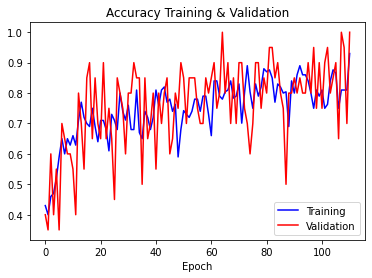

In [ ]:
plt.plot(history.history['accuracy'], label='Training', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation', color='red')
plt.title('Accuracy Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

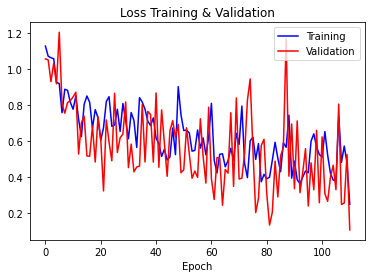

In [ ]:
plt.plot(history.history['loss'], label='Training', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='red')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

* Dapat dilihat bahwa akurasi dan loss dari data testing (validation) lebih kecil dari data training
* Jadi, model tidak overfitting

Saving pic.PNG to pic.PNG
1/1 [==============================] - 0s 35ms/step


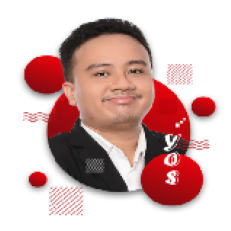

[0. 0. 1.]
Alamat file: pic.PNG
Gambar ini terdeteksi oleh sistem sebagai without_mask


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  plt.axis('Off')
  plt.imshow(img)
  plt.show()
  print(classes[0])

  predicted_class_indices=np.argmax(classes,axis=1)
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in predicted_class_indices]
  print("Alamat file:",fn)
  print("Gambar ini terdeteksi oleh sistem sebagai "+str(predictions[0]))

# Saving Model

In [ ]:
model.save('/content/drive/MyDrive/FSB/my_model')
print("Berhasil")

Berhasil


# Load Saved Model

In [ ]:
# Test
new_model = tf.keras.models.load_model('/content/drive/MyDrive/FSB/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

Saving WIN_20220915_10_55_46_Pro.jpg to WIN_20220915_10_55_46_Pro.jpg
Saving WIN_20230221_22_47_05_Pro.jpg to WIN_20230221_22_47_05_Pro.jpg
Saving WIN_20230224_12_09_40_Pro.jpg to WIN_20230224_12_09_40_Pro.jpg
Saving WIN_20230224_12_09_47_Pro.jpg to WIN_20230224_12_09_47_Pro.jpg
Saving WIN_20230224_12_09_54_Pro.jpg to WIN_20230224_12_09_54_Pro.jpg
Saving WIN_20230224_12_10_07_Pro.jpg to WIN_20230224_12_10_07_Pro.jpg
1/1 [==============================] - 1s 696ms/step


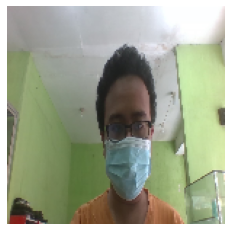

[1. 0. 0.]
Be careful! You are using incorrect mask.
1/1 [==============================] - 0s 66ms/step


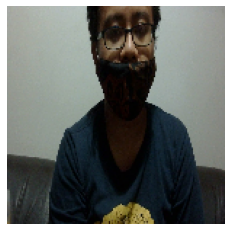

[1. 0. 0.]
Be careful! You are using incorrect mask.
1/1 [==============================] - 0s 50ms/step


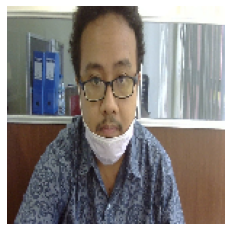

[1. 0. 0.]
Be careful! You are using incorrect mask.
1/1 [==============================] - 0s 61ms/step


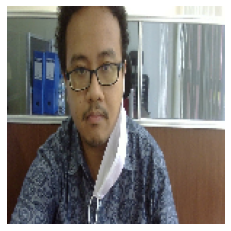

[1. 0. 0.]
Be careful! You are using incorrect mask.
1/1 [==============================] - 0s 39ms/step


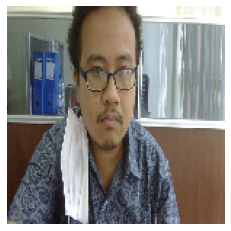

[1. 0. 0.]
Be careful! You are using incorrect mask.
1/1 [==============================] - 0s 37ms/step


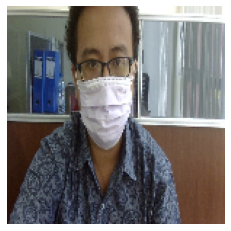

[1. 0. 0.]
Be careful! You are using incorrect mask.


In [ ]:
# Evaluate the restored model

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = new_model.predict(images, batch_size=10)
  plt.axis('Off')
  plt.imshow(img)
  plt.show()
  print(classes[0])

  if classes[0,0] != 0:
    print("Be careful! You are using incorrect mask.")
  elif classes[0,1] != 0:
    print("You are wearing correct mask! Stay healthy :)")
  else:
    print("You are not wearing mask!")

Saving 13-with-mask.jpg to 13-with-mask.jpg
1/1 [==============================] - 0s 58ms/step


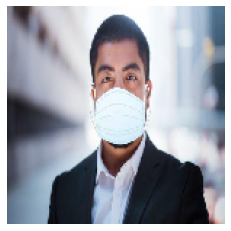

[0. 1. 0.]
You are wearing correct mask! Stay healthy :)


In [ ]:
# Evaluate the restored model
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = new_model.predict(images, batch_size=10)
  plt.axis('Off')
  plt.imshow(img)
  plt.show()
  print(classes[0])

  if classes[0,0] != 0:
    print("Be careful! You are using incorrect mask.")
  elif classes[0,1] != 0:
    print("You are wearing correct mask! Stay healthy :)")
  else:
    print("You are not wearing mask!")

Kelebihan model ini:
* Mampu mendeteksi incorrect_mask dan without_mask secara mudah

Kekurangan model ini:
* Sulit untuk mendeteksi with_mask dikarenakan data latih with_mask yang digunakan kurang mewakili orang-orang yang menggunakan masker dengan baik